# Description:
In this notebook a potential correlation between the transit curve and the ambient temperature & battery charge was investigated using the environmental data from Grafana.

# Import modules:

In [8]:
import numpy as np
import scipy as sc
import scipy.fft as scfft
import matplotlib.pyplot as plt
import uproot
import datetime as dt
from datetime import datetime
import csv
#from datetime import datetime

In [9]:
%%capture out
%run /mnt/c/Users/Jethro/Desktop/Master\ Thesis/Functions.ipynb
%run /mnt/c/Users/Jethro/Desktop/RNO-G/GalaxyFunctions.ipynb

# Import data

In [3]:
File=uproot.open("/mnt/c/Users/Jethro/Desktop/Master thesis/RNO_DATA_DIR/station11/run101/combined.root")

In [4]:
RadiantData=File['combined']['waveforms']['radiant_data[24][2048]'].array(library='np')
EventNumber=File['combined']['waveforms']['event_number'].array(library="np")
print(RadiantData.shape) #107 is for events, 24 channels & 2048 for each timestep
#np.where(EventNumber==18)[0][0]

(107, 24, 2048)


# Looking at temperature data

In [3]:
RunList=np.concatenate((np.arange(8,24),np.arange(306,310),np.arange(289,298),np.arange(284,288),np.arange(162,186)))

In [4]:
def GrafanaData(Nr,FileName):
    '''Returns Temperature data of the place with number Nr in the cvs file.'''
    with open(FileName) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        line_count = 0
        Value=np.array([])
        Time=np.array([])
        for row in csv_reader:
            if line_count == 0:
                Name=row[Nr+1]
                line_count += 1
                #print("length of row is " + str(len(row)))
            elif len(row)==0:
                break
            else:
                #print(row)
                if row[Nr+1]!="":
                    #time=row[0]
                    time=dt.datetime.strptime(row[0], '%Y-%m-%d %H:%M:%S')
                    DataCount=0
                    data=float(row[Nr+1])
                    Time=np.append(Time,time)
                    Value=np.append(Value,data)
                    #for data in row[1:]:
                    #    if data!='':
                    #        1+1
                    #        Time=np.append(Time,time)
                    #        Temp=np.append(Temp,data)
                    
                #print(f'\t{row[0]} works in the {row[1]} department, and was born in {row[2]}.')
                #print(row)
                line_count += 1
            if line_count%50000==0:
                print("progress of " + Name + " " + str(Nr) + "/" + str(len(row)-1) +" : " + str(np.round(100*line_count/477430,2)) + '%', end="\r")
        #print(f'Processed {line_count} lines.')
        #print(Data)
        return Name, Time, Value

In [13]:
Name1, Time1, Val1 = GrafanaData(2,"Temperatures-data-2022-11-22 12_14_09.csv")
print(Name1)
print(Time1)
print(Val1)

Avinngaq        ( 22)(remote 1)2)(remote 1) 2/4 : 20.95%
[datetime.datetime(2021, 7, 17, 12, 15, 46)
 datetime.datetime(2021, 7, 17, 12, 16, 46)
 datetime.datetime(2021, 7, 17, 12, 17, 46) ...
 datetime.datetime(2021, 8, 12, 6, 31, 50)
 datetime.datetime(2021, 8, 12, 6, 32, 50)
 datetime.datetime(2021, 8, 12, 6, 33, 50)]
[15.1 15.1 15.3 ... 11.4 11.4 11.5]


In [54]:
np.array([[1,2],[1,2],[1,2],[1,2]]).shape

(4, 2)

In [58]:
W=np.empty((4,10))
W[3][7]

6.90473749280183e-310

In [12]:
Name2, Time2, Val2 = GrafanaData(1,"battery voltage-data-2022-11-22 12_14_31.csv")
print(Name2)
print(Time2)
print(Val2)

Amaroq          ( 21)       ( 21) 1/4 : 20.95%
[datetime.datetime(2021, 7, 17, 12, 14, 42)
 datetime.datetime(2021, 7, 17, 12, 15, 42)
 datetime.datetime(2021, 7, 17, 12, 17, 42) ...
 datetime.datetime(2021, 8, 12, 6, 32, 7)
 datetime.datetime(2021, 8, 12, 6, 33, 7)
 datetime.datetime(2021, 8, 12, 6, 34, 7)]
[13.87 13.52 13.57 ... 12.5  12.5  12.5 ]


In [15]:
TempData=[]
for i in range(4):
    Name, Time, Temp = GrafanaData(i,"Temperatures-data-2022-11-22 12_14_09.csv")
    TempData.append([Name,Time,Temp])

In [16]:
BatData=[]
for i in range(4):
    Name, Time, BatVolt = GrafanaData(i,"battery voltage-data-2022-11-22 12_14_31.csv")
    BatData.append([Name,Time,BatVolt])

In [67]:
print(np.array([[1,2],[1,1],[2,3]]).shape)
print(np.empty((0,2),float).shape)
np.concatenate((np.empty((0,2),float),np.array([[1,2],[1,1],[2,3]])),axis=0)

(3, 2)
(0, 2)


array([[1., 2.],
       [1., 1.],
       [2., 3.]])

In [83]:
R=RunsTimeRanges(22, [101,105])
[datetime.utcfromtimestamp(f) for f in R[0]]

[[1.62742515e+09 1.62743234e+09]
 [1.62745398e+09 1.62746117e+09]]


[datetime.datetime(2021, 7, 27, 22, 32, 26),
 datetime.datetime(2021, 7, 28, 0, 32, 21)]

In [77]:
datetime(2021, 7, 23, 6, 33, 5)<datetime(2021, 7, 25, 6, 33, 5)<datetime(2021, 7, 28, 6, 33, 5)

True

In [5]:
def DailyGrafanaAvg(LocNr,FileName,TimeRanges,NBins=24):
    "Plots the average of a physical quantity at location number LocNr provided as a csv file FileName from Grafana as a function of LST during a set time ranges TimeRanges (with shape (x,2) in Unix time)"
    Name, AllTime, AllVal = GrafanaData(LocNr,FileName)
    
    Val=np.array([]) #Array to store value of each sample in the timeranges
    Time=np.array([])#Array to store timestamp of each sample in the timeranges
    
    for i in np.arange(len(AllTime)):
        for TimeRange in TimeRanges:
            if datetime.utcfromtimestamp(TimeRange[0])<AllTime[i]<datetime.utcfromtimestamp(TimeRange[1]) and (not AllTime[i] in Time):
                Val=np.append(Val,AllVal[i])
                Time=np.append(Time, AllTime[i].hour+AllTime[i].minute/60 + AllTime[i].second/3600)        
    
    TimeCounts, TimeBins=np.histogram(Time, bins=NBins,range=(0,24),density=False) #Storing timestamps in histogram format
    #Make a histogram of the V_RMS value fully added in its respective bin by adding V_RMS as a weigth to the additions to the histogram
    ValCounts, ValBins=np.histogram(Time, bins=NBins,range=(0,24),density=False,weights=Val)    

   
    MidBins= np.array([(TimeBins[i] + TimeBins[i+1])/2 for i in range(0,len(TimeBins)-1)])           
    ValAvg=np.array([ValCounts[i]/TimeCounts[i]  if TimeCounts[i] !=0 else 0 for i in range(len(ValCounts))])
    
    #Compute std per bin
    TimeDig=np.digitize(Time,TimeBins)
    GroupedVal=np.empty((NBins,),dtype=object)
    for i in range(len(TimeDig)):
        GroupedVal[TimeDig[i]-1]=np.append(GroupedVal[TimeDig[i]-1],Val[i])
    ##Get rid of "None" entries in beginning of array
    for i in range(len(GroupedVal)):
        GroupedVal[i]=np.delete(GroupedVal[i], 0) 
    ValStd=np.array([np.std(GroupedVal[i]) for i in range(len(GroupedVal))])
    
    plt.figure(figsize=(15,5))
    plt.figtext(0.2, 0.8, "Entries:" + str(np.sum(TimeCounts)), fontsize=18,bbox=dict(edgecolor='black', facecolor='none', alpha=0.2, pad=10.0))
    #for i in range(len(GroupedVal)):
    #    plt.plot(MidBins[i]*np.ones(len(GroupedVal[i])),GroupedVal[i])
    plt.errorbar(MidBins,ValAvg,yerr=ValStd,fmt=".")
    plt.grid(color='grey', linestyle='-', linewidth=1,alpha=0.5)
    plt.title("Average value for " + str(Name) + " with " + str(NBins) + " bins")
    #plt.ylim(-50,50)
    #plt.xlim(0,np.max(SamplingTimes*(10**9)))
    plt.xlabel("Local Time (hrs)",fontsize=20)#20)
    plt.ylabel("A.U.",fontsize=20)#20)
    plt.xticks(np.arange(0, 24, 1.0),fontsize=25)#15)
    plt.yticks(fontsize=25)#15)
    #plt.legend()
    plt.show()
    return Name, Time, Val

In [10]:
GroupedVal=np.array([np.array([1,8,6]),np.array([4,8]),np.array([7,3,5,4])],dtype=object)
print(GroupedVal.shape)

(3,)


In [96]:
RunListTimeRanges=RunsTimeRanges(22, RunList)

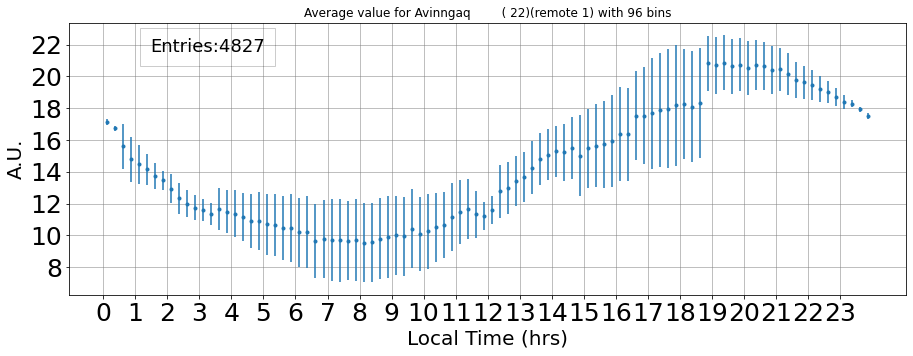

In [52]:
Name, Time, Val=DailyGrafanaAvg(2,"Temperatures-data-2022-11-22 12_14_09.csv",RunsTimeRanges(22, RunList),NBins=4*24)

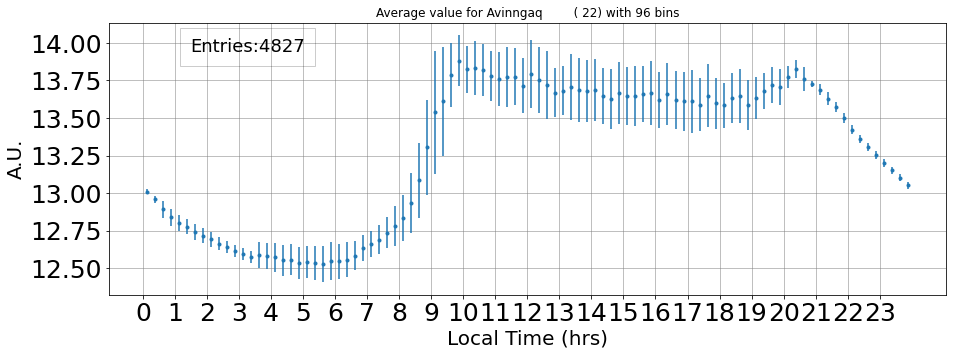

In [53]:
Name, Time, Val=DailyGrafanaAvg(2,"battery voltage-data-2022-11-22 12_14_31.csv",RunsTimeRanges(22, RunList),NBins=4*24)

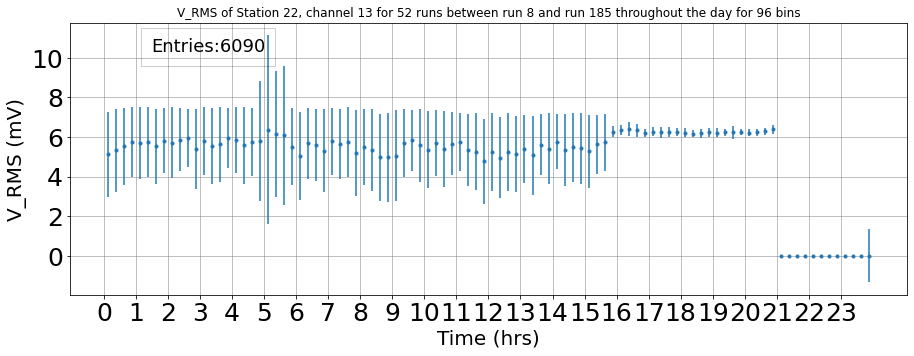

In [6]:
DailyVoltAvg(22,13,RunList,NBins=4*24,TimeFormat="LT")

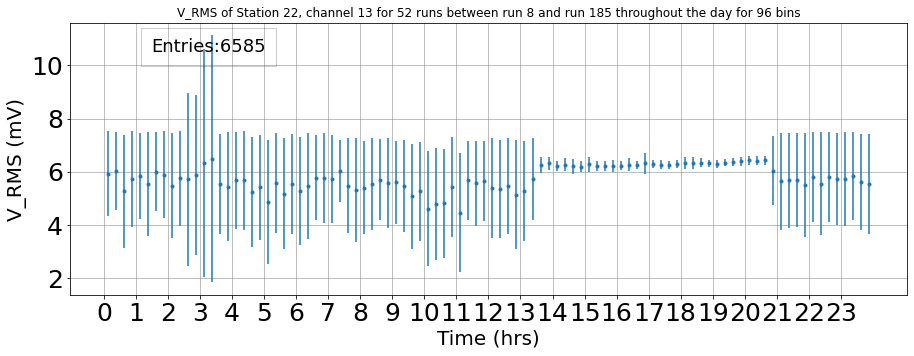

In [60]:
DailyVoltAvg(22,13,RunList,NBins=4*24)

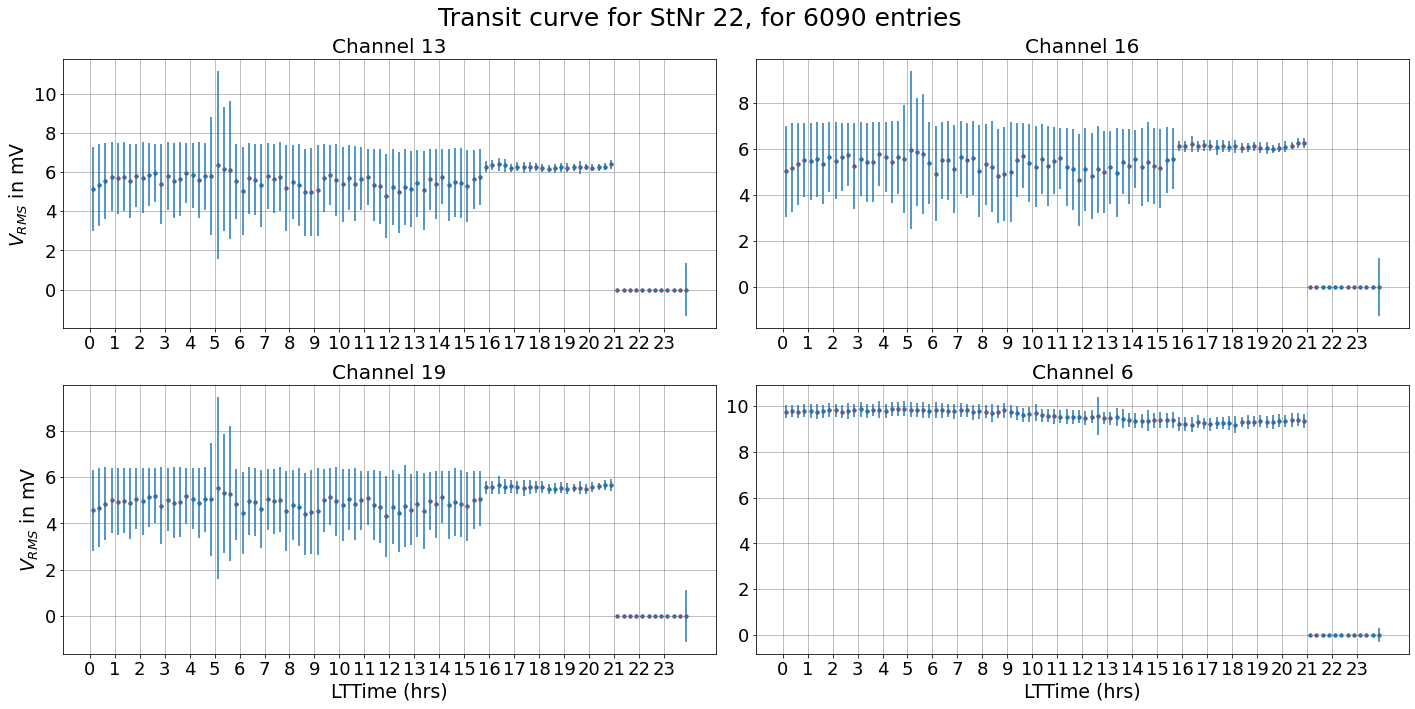

In [11]:
TransitCurves(22,6,RunList,NBins=4*24,TimeFormat="LT")

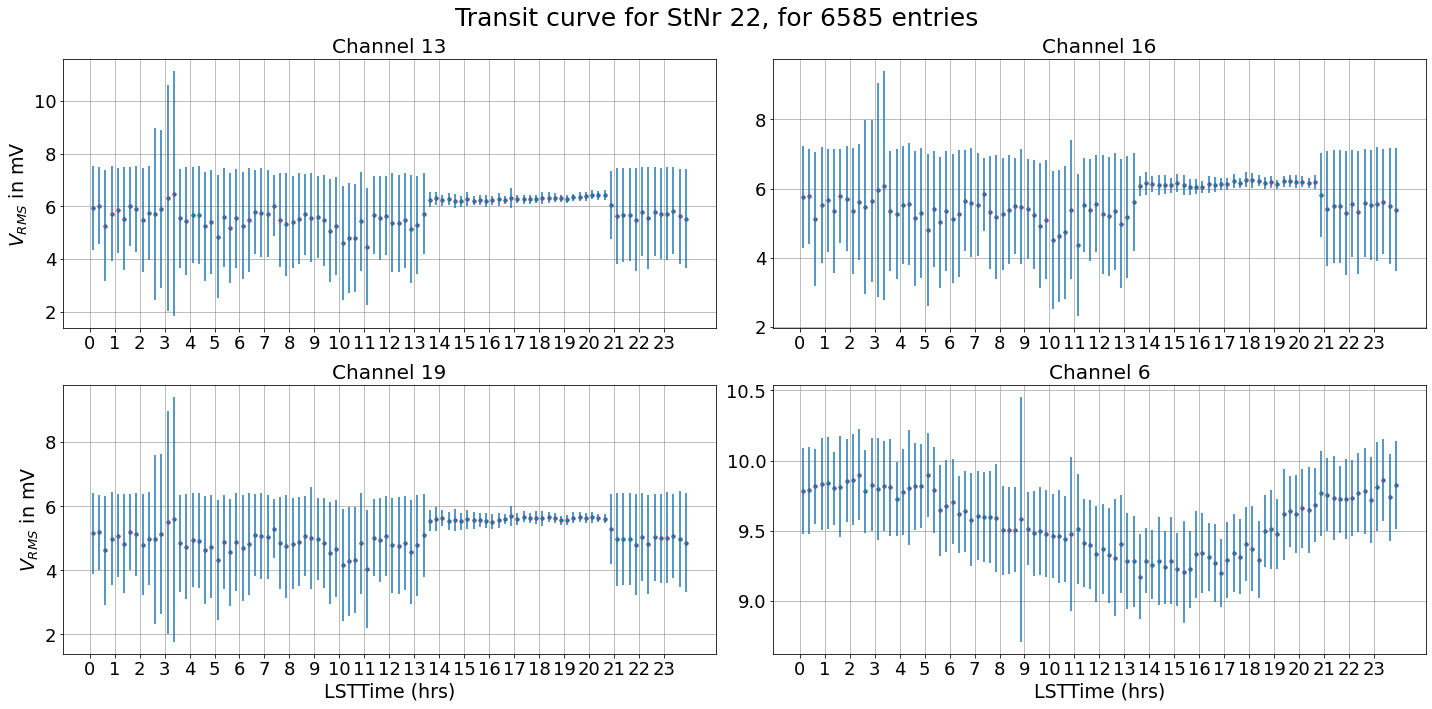

In [10]:
TransitCurves(22,6,RunList,NBins=4*24)